# Task-2

In [17]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_processing import * 
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## Load Data

In [4]:
df = load_close_data('tsla')

2024-11-14 09:56:44,809 - INFO - Loading tsla data...
[*********************100%***********************]  1 of 1 completed
2024-11-14 09:57:02,432 - INFO - Data loaded 


In [6]:
df.columns

Index(['Price'], dtype='object')

In [7]:
df.head()

,Price
Date,
2015-01-02 00:00:00+00:00,14.620667
2015-01-05 00:00:00+00:00,14.006000
2015-01-06 00:00:00+00:00,14.085333
2015-01-07 00:00:00+00:00,14.063333
2015-01-08 00:00:00+00:00,14.041333


In [8]:
# Resample to fill in missing dates
df_resampled = df.resample('D').ffill()  # Forward fill missing data

In [9]:
# Step 4: Verify frequency
print(df_resampled.index.freq)  # Should show the frequency, e.g., 'D' for daily

<Day>


In [10]:
df_resampled.head(10)

,Price
Date,
2015-01-02 00:00:00+00:00,14.620667
2015-01-03 00:00:00+00:00,14.620667
2015-01-04 00:00:00+00:00,14.620667
2015-01-05 00:00:00+00:00,14.006000
2015-01-06 00:00:00+00:00,14.085333
2015-01-07 00:00:00+00:00,14.063333
2015-01-08 00:00:00+00:00,14.041333
2015-01-09 00:00:00+00:00,13.777333
2015-01-10 00:00:00+00:00,13.777333


In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_resampled['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
result

ADF Statistic: -1.1617970192588394
p-value: 0.6898101051761021


(-1.1617970192588394,
 0.6898101051761021,
 22,
 3567,
 {'1%': -3.432184598306239,
  '5%': -2.8623506224106547,
  '10%': -2.5672015075684036},
 21426.149321488512)

- since p-value is more than 0.05 it shows the data is not stationary
- the ADF value is also greater than 1, 5, and 10% of critical values shows non stationarity of the data

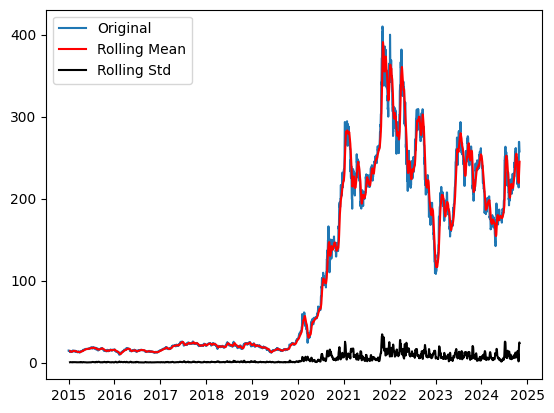

In [91]:
rolling_mean = df_resampled['Price'].rolling(window=12).mean()
rolling_std = df_resampled['Price'].rolling(window=12).std()

plt.plot(df_resampled['Price'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.show()

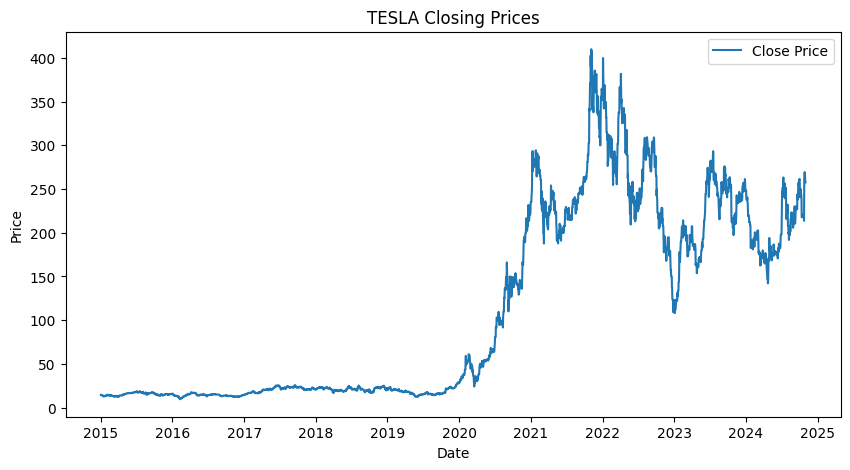

In [11]:
# Step 2: Visualize the Closing Prices
plt.figure(figsize=(10, 5))
plt.plot(df_resampled['Price'], label='Close Price')
plt.title(f'TESLA Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [152]:
df_resampled

Price,Price
Ticker,TSLA
Date,
2015-01-02 00:00:00+00:00,14.620667
2015-01-03 00:00:00+00:00,14.620667
2015-01-04 00:00:00+00:00,14.620667
2015-01-05 00:00:00+00:00,14.006000
2015-01-06 00:00:00+00:00,14.085333
...,...
2024-10-26 00:00:00+00:00,269.190002
2024-10-27 00:00:00+00:00,269.190002


In [123]:
df_resampled.isnull().sum()

Price       Ticker
Price       TSLA      0
Close_Diff            1
dtype: int64

In [149]:
# Resample to fill in missing dates
df_resampled = df.resample('D').ffill()  # Forward fill missing data

In [58]:
df_cleaned= df.copy()
df_cleaned['Close_Diff'] = df_cleaned['Price'].diff()
df_cleaned = df_cleaned.dropna()

ADF Statistic: -10.088201009165392
p-value: 1.1404778247006587e-17
Critical Values: {'1%': -3.4330273737125445, '5%': -2.8627228377894505, '10%': -2.567399672341618}


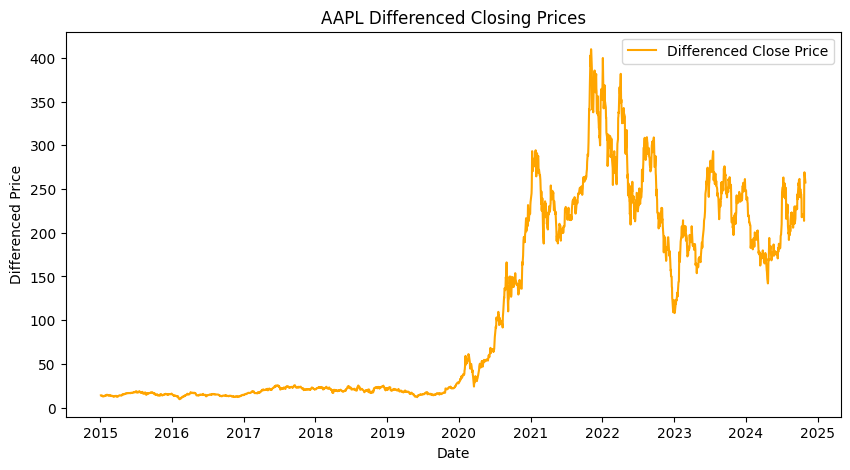

In [61]:

# Step 4: Check for Stationarity
result = adfuller(df_cleaned['Close_Diff'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Step 5: Visualize Differenced df_resampled
plt.figure(figsize=(10, 5))
plt.plot(df_cleaned['Price'], label='Differenced Close Price', color='orange')
plt.title(f'AAPL Differenced Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

### Split Data

In [12]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


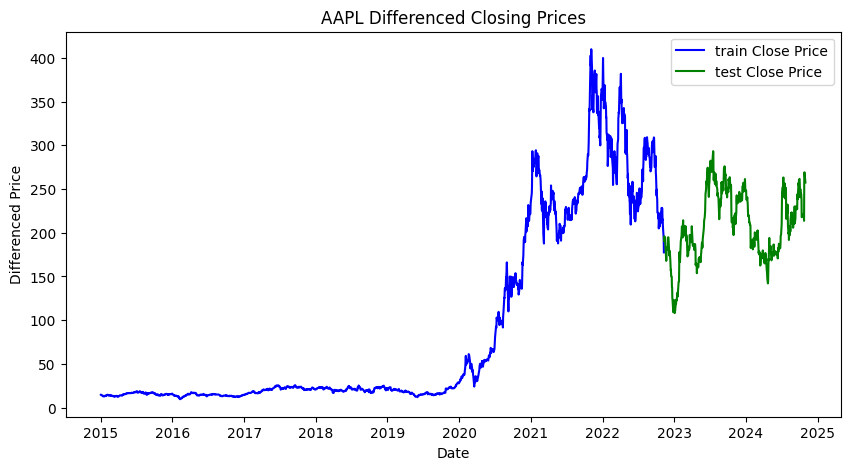

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(train['Price'], label='train Close Price', color='blue')
plt.plot(test['Price'], label='test Close Price', color='green')
plt.title(f'AAPL Differenced Closing Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

## Forecasting

### Arima Model

In [39]:
# Determine optimal parameters
stepwise_model = auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, seasonal=False, trace=True)
stepwise_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.864 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1979
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6168.668
Date:                Thu, 14 Nov 2024   AIC                          12339.337
Time:                        10:15:43   BIC                          12344.927
Sample:                             0   HQIC                         12341.391
                               - 1979                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        29.9469      0.322     92.904      0.000      29.315      30.579
===================================================================================
Ljung-Box (L1) (Q):                   3.03   Jarque-Bera (JB):             19743.15
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):             588.72   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
p, d, q = stepwise_model.order
arima_model = ARIMA(train, order=(p, d, q))
arima_result = arima_model.fit()


In [41]:
forecast_arima = arima_result.forecast(steps=len(test))
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mape_arima = np.mean(np.abs((test['Price'] - forecast_arima) / test['Price'])) * 100


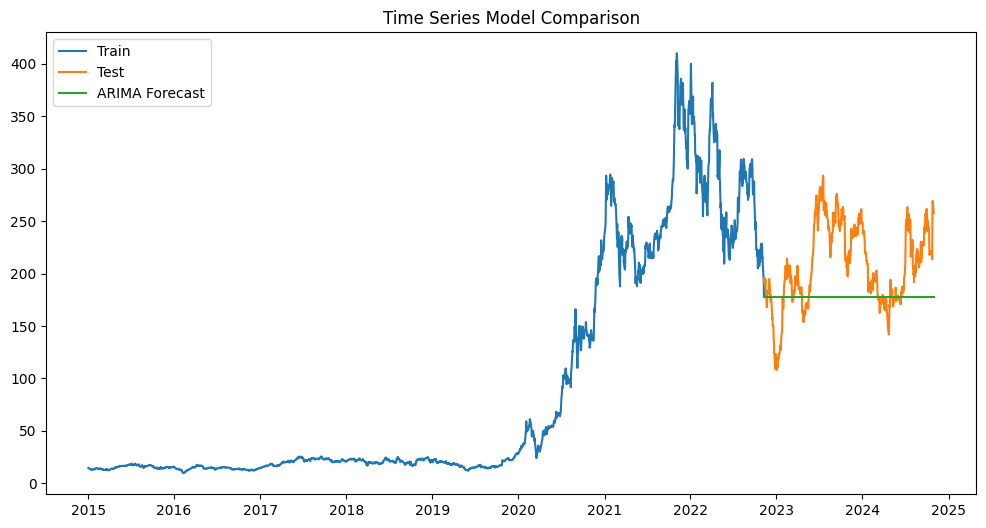

In [115]:

# Plotting results for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot( train['Price'], label='Train')
plt.plot( test['Price'], label='Test')
plt.plot( test.index, forecast_arima, label='ARIMA Forecast')
# plt.plot(test['date'], es_forecast, label='Exponential Smoothing Forecast')
# plt.plot(test['date'], prophet_forecast['yhat'][-len(test):], label='Prophet Forecast')
plt.legend(loc='upper left')
plt.title('Time Series Model Comparison')
plt.show()


### Sarima

In [13]:
# Find optimal SARIMA parameters
sarima_model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, start_P=1, seasonal=True, m=12, trace=True)
sarima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=12333.795, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12340.889, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12340.375, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12340.797, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12339.337, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=12341.629, Time=1.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=12341.254, Time=1.06 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=12311.266, Time=3.68 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=12309.266, Time=2.37 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=12308.605, Time=1.30 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12340.495, Time=0.47 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=12310.604, Time=1.74 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12333.451, Time=1.04 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=12309.188, Time=1.69 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1979
Model:             SARIMAX(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -6149.393
Date:                            Thu, 14 Nov 2024   AIC                          12306.786
Time:                                    10:00:24   BIC                          12329.145
Sample:                                         0   HQIC                         12315.000
                                           - 1979                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0369      0.012     -3.060      0.002      -0.061      -0.013
ar.S.L12       0.0235      0.014      1.716      0.086      -0.003       0.050
ar.S.L24       0.1318      0.010     12.654      0.000       0.111       0.152
sigma2        29.3627      0.313     93.752      0.000      28.749      29.977
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21959.05
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             561.15   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
print(sarima_model.order)
print(sarima_model.seasonal_order)

(1, 1, 0)
(2, 0, 0, 12)


In [18]:
p, d, q  = sarima_model.order
P, D, Q, s =  sarima_model.seasonal_order

sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

# Forecast and evaluate
forecast_sarima = sarima_result.forecast(steps=len(test))
mae_sarima = mean_absolute_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))
mape_sarima = np.mean(np.abs((test['Price'] - forecast_sarima) / test['Price'])) * 100


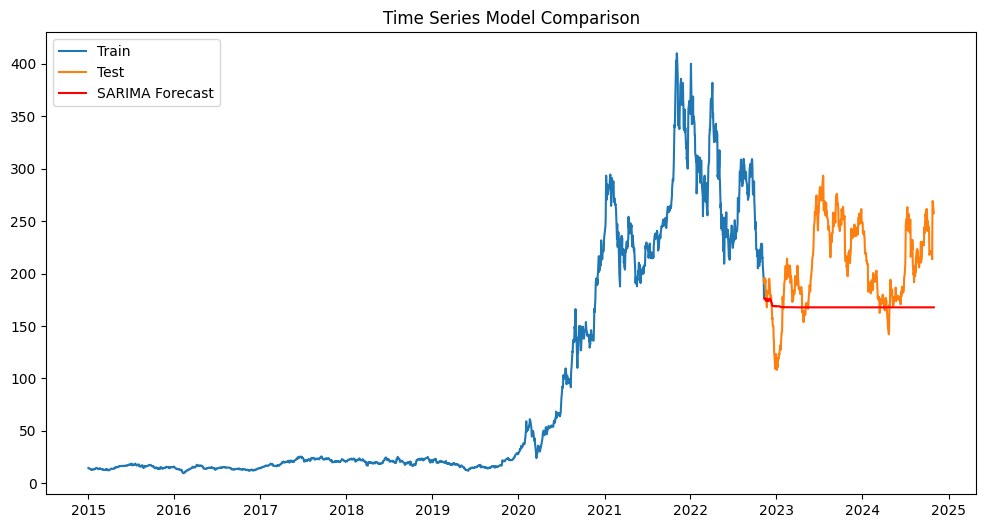

In [19]:

# Plotting results for visualization
plt.figure(figsize=(12, 6))
plt.plot( train['Price'], label='Train')
plt.plot( test['Price'], label='Test')
plt.plot( test.index, forecast_sarima, label='SARIMA Forecast', color='red')
# plt.plot(test['date'], es_forecast, label='Exponential Smoothing Forecast')
# plt.plot(test['date'], prophet_forecast['yhat'][-len(test):], label='Prophet Forecast')
plt.legend(loc='upper left')
plt.title('Time Series Model Comparison')
plt.show()


### LSTM

In [20]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Reshape into sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create train and test sequences
seq_length = 60
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size-seq_length:], seq_length)


In [223]:
X_test.shape

(495, 60, 1)

In [145]:
X_train.shape

(1919, 60, 1)

In [146]:
X_train.shape[1]

60

In [21]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile model
lstm_model.compile(optimizer="adam", loss="mean_squared_error")

# Train model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0276
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.7330e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3967e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.5383e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.8044e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.4024e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.5370e-04


In [22]:
# Forecast with LSTM model
predicted_prices = lstm_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test)

# Evaluation metrics
mae_lstm = mean_absolute_error(real_prices, predicted_prices)
rmse_lstm = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mape_lstm = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [128]:
mape_lstm

5.115394096296115

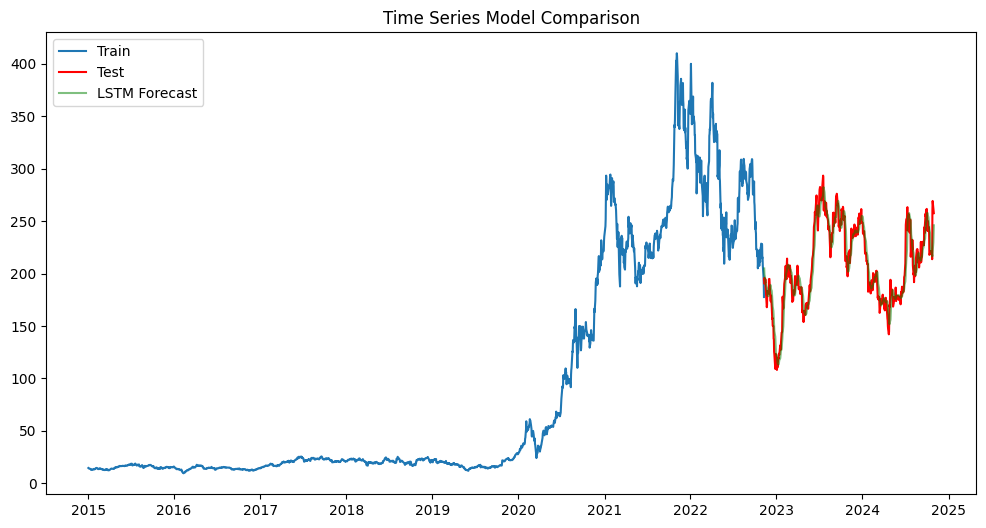

In [35]:

# Plotting results for visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot( train['Price'], label='Train')
plt.plot( test['Price'], label='Test', color='red')
plt.plot( test.index, predicted_prices, label='LSTM Forecast', color='green', alpha=0.5)
plt.legend(loc='upper left')
plt.title('Time Series Model Comparison')
plt.show()


### prophet

In [ ]:
from prophet import Prophet

# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(df)

## Evaluate and compare models

In [ ]:
ar = [mae_arima, rmse_arima, mape_arima]
sar = [mae_sarima, rmse_sarima, mape_sarima]
lstm = [ mae_lstm, rmse_lstm, mape_lstm]

compare_models(ar, sar, lstm)

+---------+----------+---------+-----------+
| Model   |      MAE |    RMSE |      MAPE |
+=========+==========+=========+===========+
| ARIMA   | 38.9071  | 49.113  | nan       |
+---------+----------+---------+-----------+
| SARIMA  | 45.285   | 55.6869 | nan       |
+---------+----------+---------+-----------+
| LSTM    |  9.47884 | 12.3772 |   4.70023 |
+---------+----------+---------+-----------+


##  Visualize Predictions

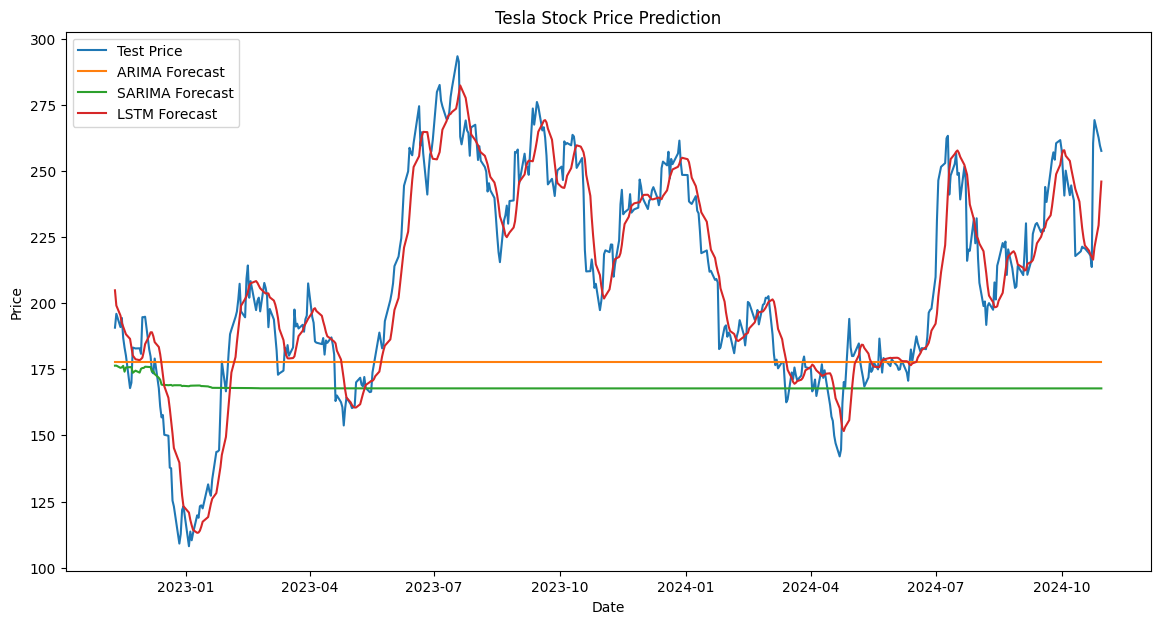

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[train_size:], test['Price'], label="Test Price")
plt.plot(df.index[train_size:], forecast_arima, label="ARIMA Forecast")
plt.plot(df.index[train_size:], forecast_sarima, label="SARIMA Forecast")
plt.plot(df.index[train_size:], predicted_prices, label="LSTM Forecast")
plt.title("Tesla Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [217]:
import joblib

# Assuming 'model' is your trained model
joblib.dump(lstm_model, '../models/best_model.pkl')

['../models/best_model.pkl']

In [ ]:
# Save the DataFrame to a CSV file
csv_file_path ='../data/'
df.to_csv(csv_file_path, index=False)

# Task-3

In [199]:
forecast_horizon = 730 


In [147]:
X_test[-1].shape

(60, 1)

In [166]:
last_sequence = X_test[-1]  # Start from the last observed sequence

In [170]:
last_sequences = last_sequence[np.newaxis, :, :]

In [ ]:
# Prepare LSTM forecast data


lstm_forecast = []
for _ in range(forecast_horizon):
    prediction = lstm_model.predict(last_sequences)
    lstm_forecast.append(prediction[0, 0])
    # Update the sequence to include the new prediction
    last_sequence = np.append(last_sequence[1:], prediction)[np.newaxis, :, np.newaxis]

# Rescale forecast back to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))


In [171]:
print(last_sequences.shape)  # Should output (timesteps, features)

(1, 60, 1)


In [156]:
print(last_sequence[np.newaxis, :, :].shape)  # Should output (timesteps, features)

(1, 60, 1)


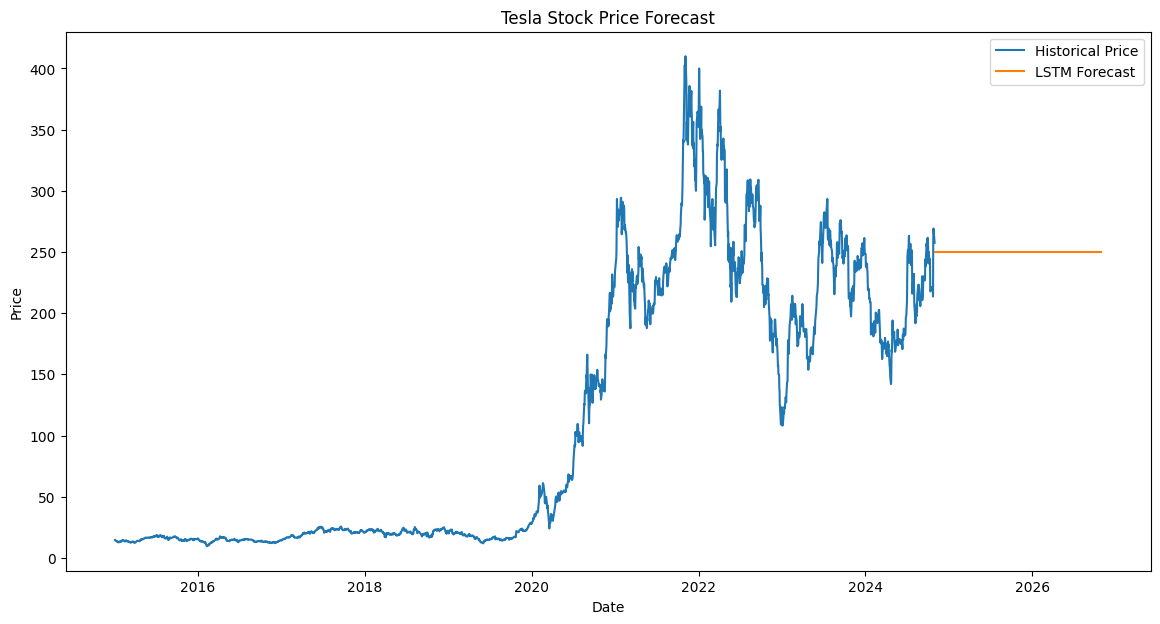

In [201]:
# Plot historical df and forecast
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["Price"], label="Historical Price")

# Plot LSTM forecast
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
plt.plot(future_dates, lstm_forecast, label="LSTM Forecast")

plt.title("Tesla Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [219]:
close_data = df['Price'].values
close_data = scaler.fit_transform(close_data)
close_data = close_data.reshape((-1,1))
close_data = close_data.reshape((-1))
look_back = 60

In [220]:
close_data.shape

(2474,)

In [221]:
X_test.shape

(495, 60, 1)

In [207]:
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df.index.values[-1]
    prediction_dates = pd.date_range(last_date+1, periods=num_prediction+1).tolist()
    return prediction_dates



In [211]:
num_prediction = 180
future_date = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=num_prediction)
forecast = predict(num_prediction, lstm_model)
forecast = forecast.reshape((num_prediction+1, 1))
forecast = scaler.inverse_transform(forecast)
forecast_dates = predict_dates(num_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [187]:
import numpy as np

# Assuming forecast is your array with shape (31,)
forecast = forecast.reshape((31, 1))

In [182]:
lstm_forecast.shape

(180, 1)

In [190]:
forecast

array([[257.54998779],
       [  2.71400452],
       [  2.81717706],
       [  2.87744522],
       [  2.90647078],
       [  2.89658809],
       [  2.85790682],
       [  2.80222249],
       [  2.73742962],
       [  2.66812301],
       [  2.5960598 ],
       [  2.52238536],
       [  2.44877005],
       [  2.37740016],
       [  2.3084209 ],
       [  2.23864174],
       [  2.16281724],
       [  2.07755661],
       [  1.983042  ],
       [  1.88202238],
       [  1.77835202],
       [  1.67574692],
       [  1.57704663],
       [  1.48385346],
       [  1.39630783],
       [  1.31327701],
       [  1.2327739 ],
       [  1.15286207],
       [  1.07275915],
       [  0.99341524],
       [  0.9171347 ]])

In [186]:
df.index

DatetimeIndex(['2015-01-02 00:00:00+00:00', '2015-01-05 00:00:00+00:00',
               '2015-01-06 00:00:00+00:00', '2015-01-07 00:00:00+00:00',
               '2015-01-08 00:00:00+00:00', '2015-01-09 00:00:00+00:00',
               '2015-01-12 00:00:00+00:00', '2015-01-13 00:00:00+00:00',
               '2015-01-14 00:00:00+00:00', '2015-01-15 00:00:00+00:00',
               ...
               '2024-10-17 00:00:00+00:00', '2024-10-18 00:00:00+00:00',
               '2024-10-21 00:00:00+00:00', '2024-10-22 00:00:00+00:00',
               '2024-10-23 00:00:00+00:00', '2024-10-24 00:00:00+00:00',
               '2024-10-25 00:00:00+00:00', '2024-10-28 00:00:00+00:00',
               '2024-10-29 00:00:00+00:00', '2024-10-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2474, freq=None)

In [ ]:
forecast_dates

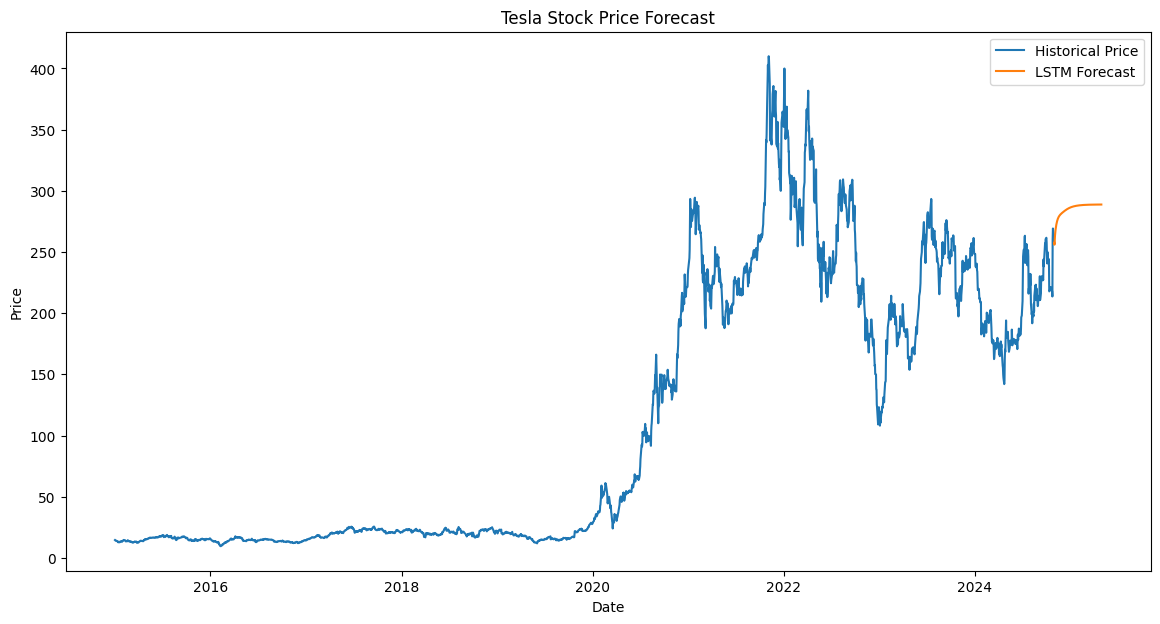

In [212]:
# Plot historical df and forecast
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["Price"], label="Historical Price")

# Plot LSTM forecast
plt.plot(forecast_dates, forecast, label="LSTM Forecast")

plt.title("Tesla Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
